In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("/Users/mac/Downloads/Building Energy/train.csv")
building = pd.read_csv("/Users/mac/Downloads/Building Energy/building_metadata.csv")
weather = pd.read_csv("/Users/mac/Downloads/Building Energy/weather_train.csv")

In [3]:
train = train.merge(building, on="building_id", how="left")
train = train.merge(weather, on=["site_id", "timestamp"], how="left")


In [4]:
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["hour"] = train["timestamp"].dt.hour
train["month"] = train["timestamp"].dt.month


In [5]:
train.drop(columns=["timestamp", "building_id"], inplace=True)

In [6]:
#Site_id are a little correlated to target columns since it describe locations
#Site_id 0 meter reading are measured as Kbtu so this needs to convert the same units with other sites
train.loc[train['site_id']==0, 'meter_reading'] *= 0.2931


In [7]:
num_cols = [
    'meter', 'site_id', 'square_feet',
    'year_built', 'floor_count',
    'air_temperature', 'cloud_coverage', 'dew_temperature',
    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed',
    'hour', 'month'
]

cat_cols = ["primary_use"]

train[num_cols] = train[num_cols].fillna(train[num_cols].median())

In [8]:
train = train.sample(n=200000,random_state=42)

In [ ]:
#train.corr(numeric_only=True)

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,month,year
building_id,1.000000,0.223132,0.009503,0.980831,0.089640,-0.160121,-0.125752,-0.308923,-0.150764,-0.107070,0.012174,0.075264,0.050026,0.000919,0.000222,0.000308,0.015717,NaN
meter,0.223132,1.000000,0.018698,0.255575,0.134245,0.002209,0.016084,-0.012512,-0.113632,-0.081929,-0.004111,-0.051033,-0.021021,-0.080356,-0.000775,-0.000596,0.004304,NaN
meter_reading,0.009503,0.018698,1.000000,0.012889,0.025557,0.000316,-0.001075,-0.003434,-0.000462,-0.002118,0.001296,-0.007294,-0.001606,0.010183,0.004787,-0.000315,-0.006859,NaN
site_id,0.980831,0.255575,0.012889,1.000000,0.092779,-0.127048,-0.134088,-0.301515,-0.127516,-0.131888,0.012574,0.054063,0.051395,0.008465,-0.000290,0.000428,0.015501,NaN
square_feet,0.089640,0.134245,0.025557,0.092779,1.000000,0.087878,0.245221,-0.014303,-0.041379,-0.024720,0.001935,-0.019493,-0.008549,-0.033119,0.003366,-0.002007,0.000837,NaN
year_built,-0.160121,0.002209,0.000316,-0.127048,0.087878,1.000000,-0.016749,0.104903,0.039938,0.064765,0.012861,-0.009591,-0.038860,-0.031802,0.000676,0.004574,-0.001436,NaN
floor_count,-0.125752,0.016084,-0.001075,-0.134088,0.245221,-0.016749,1.000000,-0.080833,-0.068834,-0.046071,-0.008757,-0.010904,0.051441,0.022609,0.002393,-0.003611,0.000526,NaN
air_temperature,-0.308923,-0.012512,-0.003434,-0.301515,-0.014303,0.104903,-0.080833,1.000000,0.092933,0.752387,0.005151,-0.308106,-0.085761,-0.082206,0.118850,0.020995,0.170148,NaN
cloud_coverage,-0.150764,-0.113632,-0.000462,-0.127516,-0.041379,0.039938,-0.068834,0.092933,1.000000,0.061054,-0.013930,-0.046691,0.012026,0.091244,0.002420,0.010472,0.000472,NaN
dew_temperature,-0.107070,-0.081929,-0.002118,-0.131888,-0.024720,0.064765,-0.046071,0.752387,0.061054,1.000000,0.069161,-0.217681,-0.161830,-0.141213,0.004078,0.020287,0.242080,NaN


In [9]:
X = train.drop(columns=["meter_reading"])
y = np.log1p(train["meter_reading"])

In [10]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [11]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [13]:
pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LinearRegression())
    ]
)


<Axes: >

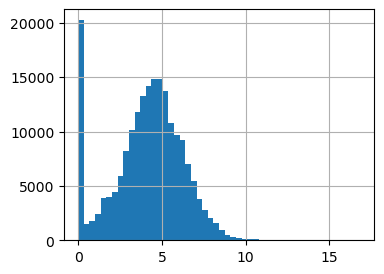

In [14]:
y.hist(figsize=(4,3),bins=50)


In [15]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


In [20]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

#pred = np.expm1(pipeline.predict(X_test))
#pred = np.maximum(0,pred)



In [21]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)

print(mse)
print(rmse)

3.616385237384594
1.9016795832591236


In [22]:
with open("building_pipeline_app1.1.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("Pipeline model saved")

Pipeline model saved
